In [50]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error

In [2]:
 path = '/content/drive/MyDrive/기상청 데이터/'
#path = '../data/'

X = pd.read_csv(path+'X_Rnn.csv', encoding='CP949')
y = pd.read_csv(path+'y_Rnn.csv', encoding='CP949')

In [3]:
X_orange = X[X['소분류_감귤/한라봉/오렌지']==1].loc[:,['날짜','평균기온(°C)','최저기온(°C)','최고기온(°C)','최소 상대습도(%)','평균 상대습도(%)','O3','PM10']]
y_orange = y[X['소분류_감귤/한라봉/오렌지']==1]

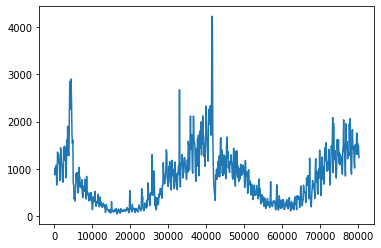

In [4]:
plt.plot(y_orange.합계)
plt.show()

# 판매량으로 판매량 예측

In [9]:
sale = y_orange.합계.values.reshape(-1,1)

sale_sc = MinMaxScaler(feature_range = (0, 1))
sale_scaled = sale_sc.fit_transform(sale)

In [10]:
def dataset(df, day): # 코드 꼭 다시 돌려보기
    X_train = []
    y_train = []
    for i in range(day, df.shape[0]):
        X_train.append(df[i-day:i, :])
        y_train.append(df[i, -1])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))
    return X_train, y_train

In [12]:
train = sale_scaled[:490]
test = sale_scaled[490:]

In [13]:
print(train.shape)
print(test.shape)

(490, 1)
(210, 1)


In [15]:
X_train, y_train = dataset(train, 20)
X_test, y_test = dataset(test, 20)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(470, 20, 1)
(470,)
(190, 20, 1)
(190,)


In [18]:
with tf.device('/device:GPU:0'):

  regressor = Sequential()

  # Setting Model
  regressor.add(LSTM(units = 100, return_sequences = True, 
                    input_shape = (X_train.shape[1], 1))) 
  regressor.add(Dropout(0.4, seed = 1))
  regressor.add(LSTM(units = 100, return_sequences = True)) 
  regressor.add(Dropout(0.4, seed = 2))
  regressor.add(LSTM(units = 100, return_sequences = True))
  regressor.add(Dropout(0.4, seed = 3))
  regressor.add(LSTM(units = 100, return_sequences = True))
  regressor.add(Dropout(0.4, seed = 4))
  regressor.add(LSTM(units = 100))
  regressor.add(Dropout(0.4, seed = 5))
  regressor.add(Dense(units = 1))

  # Compiling the RNN
  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error') 

  # fit the model
  regressor.fit(X_train, y_train, epochs = 200, batch_size = 32)

  # predict 
  pre_sale_20 = regressor.predict(X_test)

Epoch 1/200
15/15 [==============================] - 12s 13ms/step - loss: 0.0192
Epoch 2/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0129
Epoch 3/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0109
Epoch 4/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0133
Epoch 5/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0120
Epoch 6/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0133
Epoch 7/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0108
Epoch 8/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0100
Epoch 9/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0111
Epoch 10/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0111
Epoch 11/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0109
Epoch 12/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0103
Epoch 13/200
15/15 [====

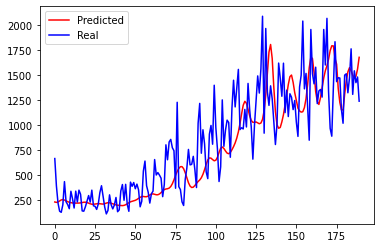

In [21]:
pre_val = sale_sc.inverse_transform(pre_sale_20.reshape(-1, 1))
true_val = sale_sc.inverse_transform(y_test.reshape(-1, 1))

plt.plot(pre_val, color = 'red', label = 'Predicted')
plt.plot(true_val, color = 'blue', label = 'Real')
plt.legend()
plt.show()

In [26]:
mse = mean_squared_error(pre_val, true_val)
print('MSE:', mse)
print('RMSE:', np.sqrt(mse))

MSE: 88422.14547851816
RMSE: 297.3586142665421


# 날씨와 판매량으로 판매량 예측

In [30]:
X_orange.head()

,날짜,평균기온(°C),최저기온(°C),최고기온(°C),최소 상대습도(%),평균 상대습도(%),O3,PM10
80,2018-01-01,0.066157,-3.463993,4.734708,20.763179,41.267581,0.015544,44.032069
194,2018-01-02,-0.000201,-3.617037,4.293367,25.960511,47.229263,0.013179,53.742579
309,2018-01-03,-2.328937,-4.948951,1.733667,27.184564,39.916465,0.017566,34.601134
424,2018-01-04,-2.419582,-6.149132,1.320985,31.627278,44.077518,0.011983,42.672343
539,2018-01-05,-0.734189,-3.487800,3.788739,30.797391,50.195533,0.011894,51.988526


In [31]:
X_orange.columns

Index(['날짜', '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '최소 상대습도(%)', '평균 상대습도(%)',
       'O3', 'PM10'],
      dtype='object')

In [35]:
mean_temp_sc = MinMaxScaler(feature_range = (0, 1))
min_temp_sc = MinMaxScaler(feature_range = (0, 1))
max_temp_sc = MinMaxScaler(feature_range = (0, 1))
min_humid_sc = MinMaxScaler(feature_range = (0, 1))
mean_humid_sc = MinMaxScaler(feature_range = (0, 1))
ozon_sc = MinMaxScaler(feature_range = (0, 1))
dust_sc = MinMaxScaler(feature_range = (0, 1))

mean_temp_scaled = mean_temp_sc.fit_transform(X_orange['평균기온(°C)'].values.reshape(-1,1))
min_temp_scaled = min_temp_sc.fit_transform(X_orange['최저기온(°C)'].values.reshape(-1,1))
max_temp_scaled = max_temp_sc.fit_transform(X_orange['최고기온(°C)'].values.reshape(-1,1))
min_humid_scaled = min_humid_sc.fit_transform(X_orange['최소 상대습도(%)'].values.reshape(-1,1))
mean_humid_scaled = mean_humid_sc.fit_transform(X_orange['평균 상대습도(%)'].values.reshape(-1,1))
ozon_scaled = ozon_sc.fit_transform(X_orange['O3'].values.reshape(-1,1))
dust_scaled = dust_sc.fit_transform(X_orange['PM10'].values.reshape(-1,1))

In [36]:
total = np.hstack([mean_temp_scaled,min_temp_scaled,
                   max_temp_scaled,min_humid_scaled,
                   mean_humid_scaled,ozon_scaled,
                   dust_scaled, sale_scaled ])

In [37]:
total.shape

(700, 8)

In [38]:
train = total[:490]
test = total[490:]
print(train.shape)
print(test.shape)

(490, 8)
(210, 8)


In [40]:
X_train, y_train = dataset(train,20)
X_test, y_test = dataset(test,20)

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(470, 20, 8)
(470,)
(190, 20, 8)
(190,)


In [43]:
with tf.device('/device:GPU:0'):

  regressor = Sequential()

  # Setting Model
  regressor.add(LSTM(units = 100, return_sequences = True, 
                    input_shape = (X_train.shape[1], X_train.shape[2]))) 
  regressor.add(Dropout(0.4, seed = 1))
  regressor.add(LSTM(units = 100, return_sequences = True)) 
  regressor.add(Dropout(0.4, seed = 2))
  regressor.add(LSTM(units = 100, return_sequences = True))
  regressor.add(Dropout(0.4, seed = 3))
  regressor.add(LSTM(units = 100, return_sequences = True))
  regressor.add(Dropout(0.4, seed = 4))
  regressor.add(LSTM(units = 100))
  regressor.add(Dropout(0.4, seed = 5))
  regressor.add(Dense(units = 1))

  # Compiling the RNN
  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error') 

  # fit the model
  regressor.fit(X_train, y_train, epochs = 200, batch_size = 32)

  # predict 
  pre_sale_20_col8 = regressor.predict(X_test)

Epoch 1/200
15/15 [==============================] - 5s 13ms/step - loss: 0.0203
Epoch 2/200
15/15 [==============================] - 0s 12ms/step - loss: 0.0134
Epoch 3/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0100
Epoch 4/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0106
Epoch 5/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0101
Epoch 6/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0106
Epoch 7/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0105
Epoch 8/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0106
Epoch 9/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0098
Epoch 10/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0096
Epoch 11/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0100
Epoch 12/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0093
Epoch 13/200
15/15 [=====

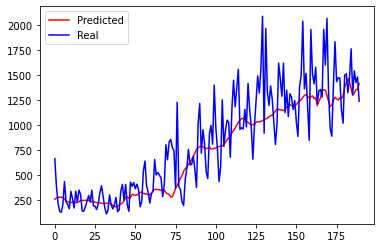

In [45]:
pre_val = sale_sc.inverse_transform(pre_sale_20_col8.reshape(-1, 1))
true_val = sale_sc.inverse_transform(y_test.reshape(-1, 1))

plt.plot(pre_val, color = 'red', label = 'Predicted')
plt.plot(true_val, color = 'blue', label = 'Real')
plt.legend()
plt.show()

In [48]:
mse = mean_squared_error(pre_val, true_val)
print('MSE:', mse)
print('RMSE:', np.sqrt(mse))

MSE: 69150.73366301824
RMSE: 262.96527083061414


In [51]:
with tf.device('/device:GPU:0'):

  regressor = Sequential()

  # Setting Model
  regressor.add(GRU(units = 100, return_sequences = True, 
                    input_shape = (X_train.shape[1], X_train.shape[2]))) 
  regressor.add(Dropout(0.4, seed = 1))
  regressor.add(GRU(units = 100, return_sequences = True)) 
  regressor.add(Dropout(0.4, seed = 2))
  regressor.add(GRU(units = 100, return_sequences = True))
  regressor.add(Dropout(0.4, seed = 3))
  regressor.add(GRU(units = 100, return_sequences = True))
  regressor.add(Dropout(0.4, seed = 4))
  regressor.add(GRU(units = 100))
  regressor.add(Dropout(0.4, seed = 5))
  regressor.add(Dense(units = 1))

  # Compiling the RNN
  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error') 

  # fit the model
  regressor.fit(X_train, y_train, epochs = 200, batch_size = 32)

  # predict 
  pre_sale_20_col8 = regressor.predict(X_test)

Epoch 1/200
15/15 [==============================] - 6s 12ms/step - loss: 0.0236
Epoch 2/200
15/15 [==============================] - 0s 11ms/step - loss: 0.0122
Epoch 3/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0094
Epoch 4/200
15/15 [==============================] - 0s 9ms/step - loss: 0.0110
Epoch 5/200
15/15 [==============================] - 0s 9ms/step - loss: 0.0090
Epoch 6/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0102
Epoch 7/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0092
Epoch 8/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0097
Epoch 9/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0103
Epoch 10/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0103
Epoch 11/200
15/15 [==============================] - 0s 9ms/step - loss: 0.0095
Epoch 12/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0091
Epoch 13/200
15/15 [========

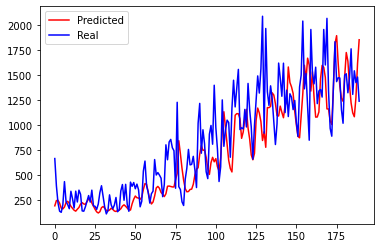

In [52]:
pre_val = sale_sc.inverse_transform(pre_sale_20_col8.reshape(-1, 1))
true_val = sale_sc.inverse_transform(y_test.reshape(-1, 1))

plt.plot(pre_val, color = 'red', label = 'Predicted')
plt.plot(true_val, color = 'blue', label = 'Real')
plt.legend()
plt.show()

In [53]:
mse = mean_squared_error(pre_val, true_val)
print('MSE:', mse)
print('RMSE:', np.sqrt(mse))

MSE: 89920.17631234572
RMSE: 299.8669310083153
